In [ ]:
# Продолжайте развитие и анализ сгененированных данных.
# 4.1. На выбор, реализация текстурных характеристик:
#  - Признаки Тамура
#  - матрица взаимной встречаемости
# 4.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных:
# https://scikit-learn.ru/stable/modules/clustering.html
# 4.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
# 4.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации:
# https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation
# 4.4. Визуализируйте результат сегментации
# 4.5 Рассчитайте характеристики(описание формы) объектов.
# 4.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.


Изображения 1 
Текстурные характеристики: {'contrast': np.float64(0.08510263480392156), 'energy': np.float64(0.7544209150847108)}
Найдено объектов 120
Средняя площадь 2477.9
Оценка сегментации 0.4649510902109234
Время обработки 1.61 сек


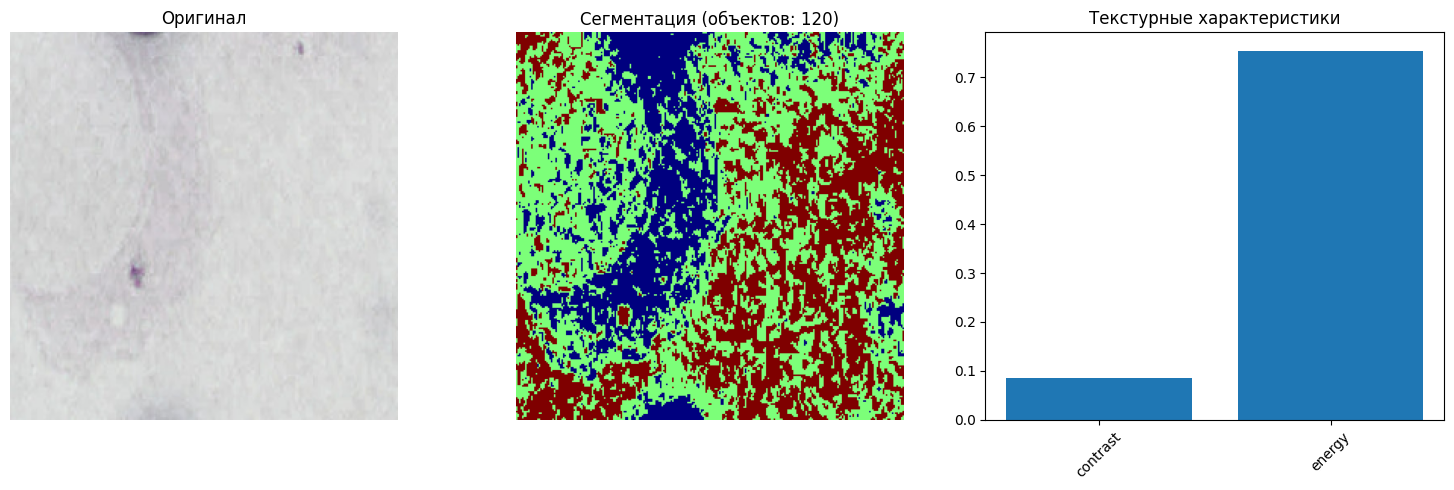


Изображения 2 
Текстурные характеристики: {'contrast': np.float64(0.09967064950980395), 'energy': np.float64(0.37398076112866296)}
Найдено объектов 74
Средняя площадь 2767.1
Оценка сегментации 0.5202587443465333
Время обработки 1.24 сек


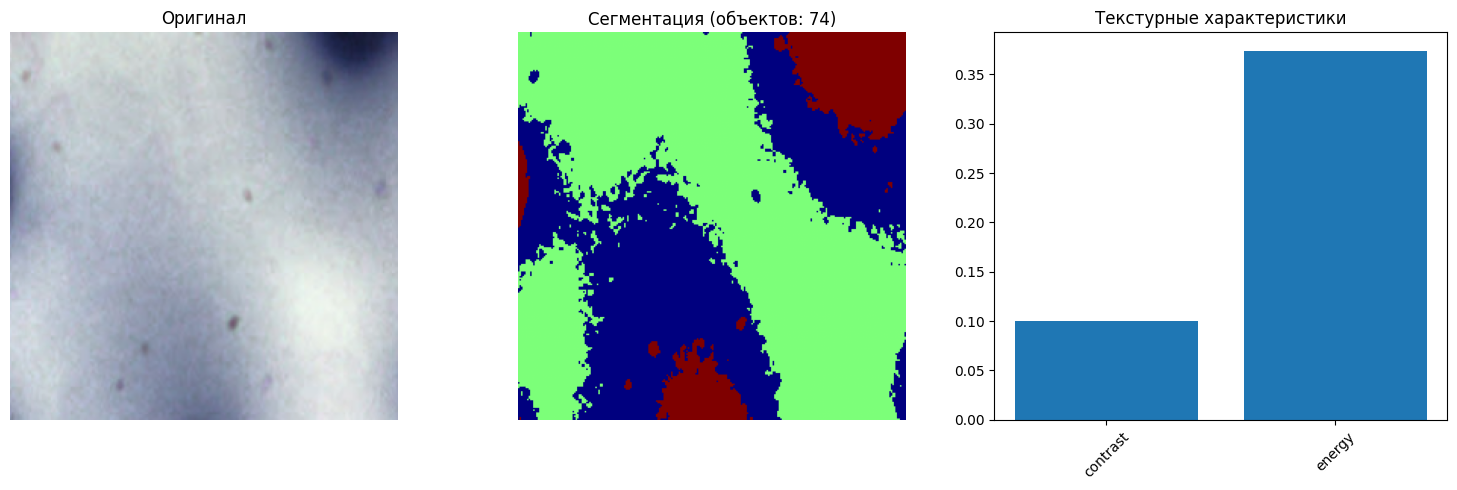


Изображения 3 
Текстурные характеристики: {'contrast': np.float64(0.11099111519607846), 'energy': np.float64(0.3604125183667332)}
Найдено объектов 2
Средняя площадь 16305.0
Оценка сегментации 0.702715686122333
Время обработки 0.96 сек


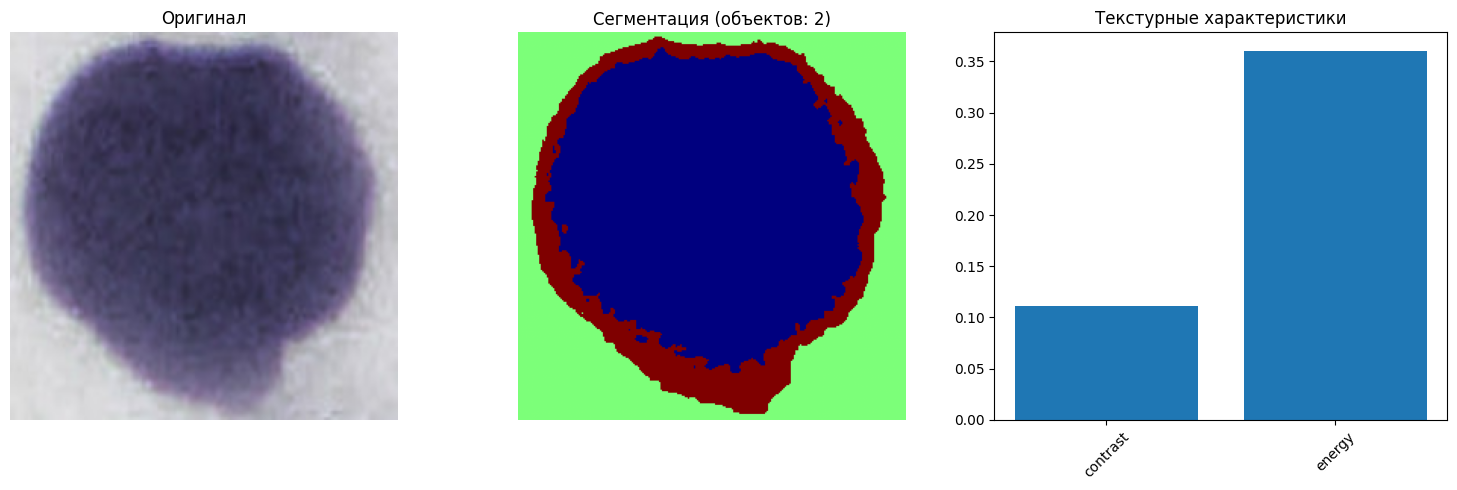


Изображения 4 
Текстурные характеристики: {'contrast': np.float64(0.04200367647058824), 'energy': np.float64(0.5871304989859971)}
Найдено объектов 7
Средняя площадь 11232.6
Оценка сегментации 0.772885688881937
Время обработки 1.37 сек


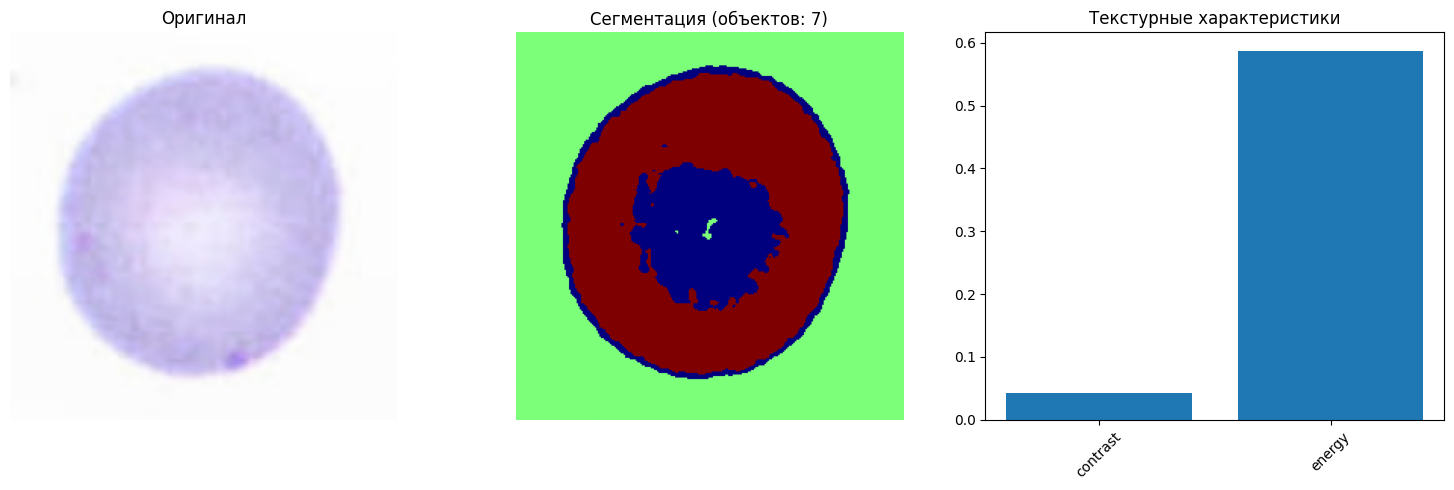


Изображения 5 
Текстурные характеристики: {'contrast': np.float64(0.27216605392156856), 'energy': np.float64(0.5452685610196757)}
Найдено объектов 23
Средняя площадь 3126.0
Оценка сегментации 0.7308244767099459
Время обработки 1.22 сек


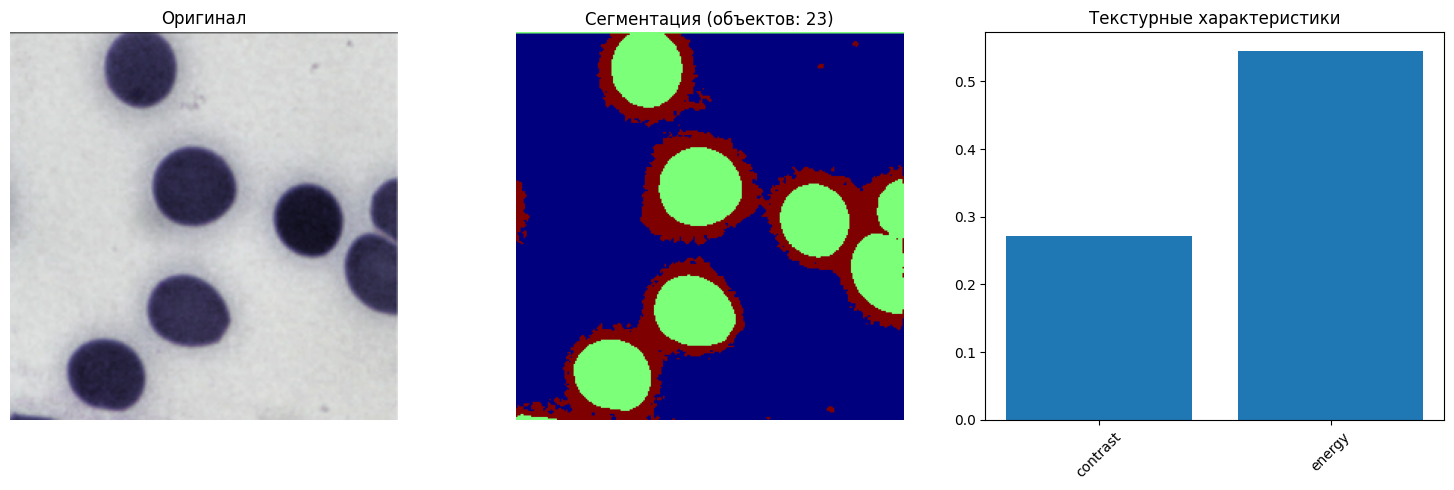

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, measure
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from skimage.filters import threshold_otsu
import time

def load_and_preprocess_images():
    images = []
    input_dir = '/content/1'

    for i in range(1, 6):
        img_path = os.path.join(input_dir, f'clear_image_{i}.png')
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            images.append(img)
        else:
            print(f"Не удалось загрузить изображение {i}")
    return images

def extract_glcm_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = (gray / 16).astype(np.uint8)

    distances = [1]
    angles = [0, np.pi/2]
    glcm = feature.graycomatrix(gray, distances=distances, angles=angles,
                              levels=16, symmetric=True, normed=True)

    contrast = feature.graycoprops(glcm, 'contrast').mean()
    energy = feature.graycoprops(glcm, 'energy').mean()

    return {'contrast': contrast, 'energy': energy}

def segment_kmeans_fast(img, n_clusters=3):
    h, w = img.shape[:2]
    pixels = img.reshape(-1, 3).astype(np.float32)

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(pixels)

    return labels.reshape(h, w)

def segment_adaptive_threshold(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray)
    binary = gray > thresh
    return binary.astype(int)

def evaluate_segmentation_simple(img, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        pixels = img.reshape(-1, 3)[::10]
        labels_sampled = labels.reshape(-1)[::10]
        silhouette = silhouette_score(pixels, labels_sampled)
    else:
        silhouette = -1
    return {'silhouette': silhouette}

def find_and_analyze_components(labels):
    binary = (labels > 0).astype(np.uint8)
    num_labels, labeled_image = cv2.connectedComponents(binary)

    if num_labels > 1:
        regions = measure.regionprops(labeled_image)
        areas = [r.area for r in regions if r.area > 10]
        mean_area = np.mean(areas) if areas else 0
    else:
        mean_area = 0
    return num_labels - 1, mean_area

def visualize_results_simple(original, segmented, features, evaluation, n_objects):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Оригинал')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented, cmap='jet')
    plt.title(f'Сегментация (объектов: {n_objects})')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.bar(features.keys(), features.values())
    plt.title('Текстурные характеристики')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def process_images_optimized():
    images = load_and_preprocess_images()

    for i, img in enumerate(images, 1):
        print(f"\nИзображения {i} ")
        start_time = time.time()

        features = extract_glcm_features(img)
        print("Текстурные характеристики:", features)

        segmented = segment_kmeans_fast(img, n_clusters=3)

        n_objects, mean_area = find_and_analyze_components(segmented)
        print(f"Найдено объектов {n_objects}")
        print(f"Средняя площадь {mean_area:.1f}")
        evaluation = evaluate_segmentation_simple(img, segmented)
        print("Оценка сегментации", evaluation['silhouette'])
        print(f"Время обработки {time.time() - start_time:.2f} сек")
        visualize_results_simple(img, segmented, features, evaluation, n_objects)

if __name__ == "__main__":
    process_images_optimized()